# Introduction:

The dataset for further analysis is customer service log from a certain company.

# The questions about this dataset:

How many channels are typically required for a single call? 

Can you provide a range for the duration of calls? 

Are there specific trends describing whether calls are solved? 

Which channels should we prioritize for improvement? 

How should we measure the success of future improvement?

In [1]:
# Import the required library
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load the csv file and convert it to be a pandas dataframe and print out the head
df = pd.read_csv("call_logging.csv")
df.head()

,time,is_solved,userId,channelName
0,1.556374e+09,0,26643,channel_0
1,1.546934e+09,0,636656,channel_1
2,1.544429e+09,0,485014,channel_2
3,1.547461e+09,0,772798,channel_1
4,1.546843e+09,0,877701,channel_3


In [3]:
# Check the rows and columns of this dataset
df.shape  

(14772712, 4)

In [4]:
# Check datatypes 
df.dtypes

time           float64
is_solved        int64
userId           int64
channelName     object
dtype: object

In [5]:
# Check each columns number of unique values 
df.nunique()

time           7929452
is_solved            2
userId         1000976
channelName         23
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14772712 entries, 0 to 14772711
Data columns (total 4 columns):
 #   Column       Dtype  
---  ------       -----  
 0   time         float64
 1   is_solved    int64  
 2   userId       int64  
 3   channelName  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 450.8+ MB


In [7]:
# Check null values in each column
df.isnull().sum()

time           146601
is_solved           0
userId              0
channelName    219224
dtype: int64

In [8]:
# Drop all rows with all NaN and NaT values in "channelName" AND "time" columns
df.dropna(inplace=True)

In [9]:
# Confirm the deletion
df.isnull().sum()

time           0
is_solved      0
userId         0
channelName    0
dtype: int64

In [10]:
# Check if there are some duplicates
df.duplicated().sum()

86

In [11]:
# Drop the duplicates
df.drop_duplicates(inplace=True)

In [12]:
# Confirm the deletion of duplicates
df.duplicated().sum()

0

In [13]:
# Convert the UNIX time format to pandas datetime
df["time"] = pd.to_datetime(df["time"], unit="s")

### How many channels are typically required for a single call?

In [14]:
# Count the channels used for each customer
# Deactivate multiindexing for easier use
channels_used = df.groupby(["userId"], as_index=False)["channelName"].value_counts()
channels_used

,userId,channelName,count
0,1,channel_5,4
1,1,channel_3,2
2,1,channel_0,1
3,1,channel_4,1
4,1,channel_2,1
...,...,...,...
6990849,10001000,channel_2,23
6990850,10001000,channel_15,19
6990851,10001000,channel_18,13
6990852,10001000,channel_21,9


In [15]:
# Count how many channels that were used only once for each customer
counts_of_channels_used_only_once = channels_used.groupby(["userId"], as_index=False).sum()
counts_of_channels_used_only_once.head(10)

/tmp/ipykernel_273/3751260134.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  counts_of_channels_used_only_once = channels_used.groupby(["userId"], as_index=False).sum()


,userId,count
0,1,14
1,2,6
2,3,15
3,4,11
4,5,14
5,6,12
6,7,9
7,8,7
8,9,11
9,10,9


In [33]:
# Convert groupby series to dataframe and reset the index
user_df = pd.DataFrame(counts_of_channels_used_only_once)
user_df

,userId,counts_of_channels_used_only_once
0,1,14
1,2,6
2,3,15
3,4,11
4,5,14
...,...,...
1000963,10000996,3711
1000964,10000997,3712
1000965,10000998,3690
1000966,10000999,3665


In [30]:
# Rename the "count" column
user_df.rename(columns={"count": "counts_of_channels_used_only_once"}, inplace=True)

The typical channels required for a single call are:

In [31]:
# Use arithmetic mean to find the typical channels required for a single call
channels_typically_required_for_a_single_call = int(user_df["counts_of_channels_used_only_once"].mean(numeric_only=True).round())
f"{channels_typically_required_for_a_single_call} channels"

'14 channels'

### Can you provide a range for the duration of calls?

In [19]:
# Sort the data by time
df.sort_values(by="time", inplace=True)

In [20]:
# Get the time interval between two adjacent calls
df["time_interval"] = df["time"].diff().apply(lambda x: x.total_seconds())

The range for the duration of the calls is:

In [21]:
# Calculate the range of duration of calls by subtracting the maximum with the minimum value 
range_of_duration_of_calls = int(df["time_interval"].max() - df["time_interval"].min())
f"{range_of_duration_of_calls} seconds"

'78 seconds'

### Are there specific trends describing whether calls are solved?

In [22]:
# Drop the time_interval column
df.drop(columns="time_interval", inplace=True)

 Count, for each hour, the number of calls that were received from all of the recorded data. 

In [23]:
# Group by the hours of calls received and count how many calls that were received
hour_grp_is_solved = df.groupby([df["time"].dt.hour], as_index=False)["is_solved"].value_counts()

The trend based on the hours of calls that were solved is skewed to the left. Which means the majority of the calls that were solved, as hours goes by, were decreased.

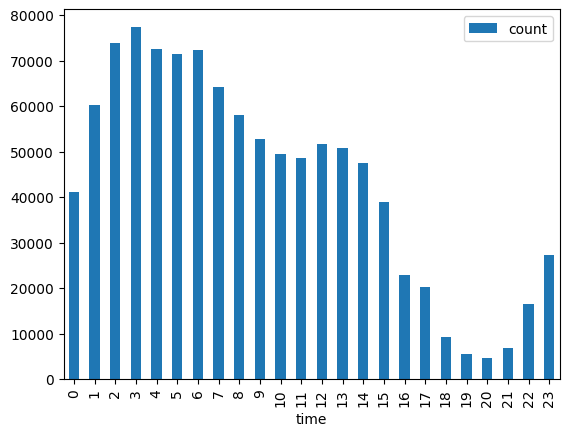

In [108]:
# Visualize the calls that were solved by each hour
hour_grp_is_solved.loc[hour_grp_is_solved["is_solved"] == 1].plot(x="time", y="count", kind="bar")
plt.show()

 Count the calls that were received from all of the recorded data on each day. 

In [96]:
# Group by the days of calls received and count how many calls that were solved or not
day_grp_is_solved = df.groupby([df["time"].dt.day_name()], as_index=False)["is_solved"].value_counts()

# Sort the data by the day name of a week
sort = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
day_grp_is_solved["time"] = pd.Categorical(day_grp_is_solved["time"], categories=sort, ordered=True)
day_grp_is_solved = day_grp_is_solved.sort_values("time")

# Rename "time" column to "day_name"
day_grp_is_solved.rename(columns={"time": "day_name"}, inplace=True)

For most of the days, the number of calls that were solved were decreased.

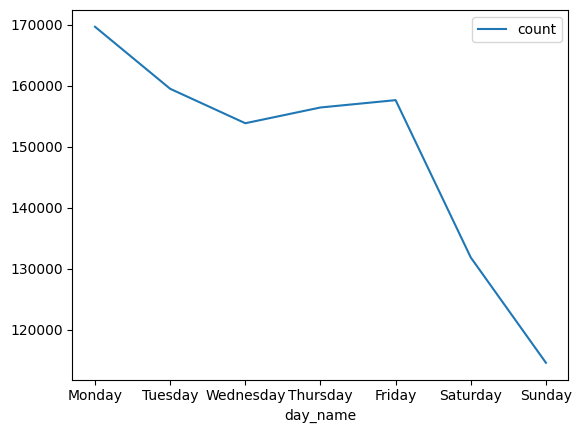

In [104]:
day_grp_is_solved.loc[day_grp_is_solved["is_solved"] == 1].plot(x="day_name", y="count")
plt.show()

 Count the number of calls that were received from all of the recorded data for each channel. 

In [27]:
# Group by channels that received the calls and count how many calls that were solved or not 
channel_grp_is_solved = df.groupby("channelName", as_index=False)["is_solved"].value_counts()

# Extract the digits in channel's name and convert it to integer and make new column out of it
channel_grp_is_solved["sort"] = channel_grp_is_solved["channelName"].str.extract("(\d+)").astype(int)

# Sort the dataframe by the values of "sort"
channel_grp_is_solved.sort_values("sort", inplace=True)

# Delete the "sort" column
channel_grp_is_solved = channel_grp_is_solved.drop("sort", axis=1)

Assuming the larger the number in channel names, the newer it was made, channels that were created first, for the most part, has better performance compared to the channels created afterwards.

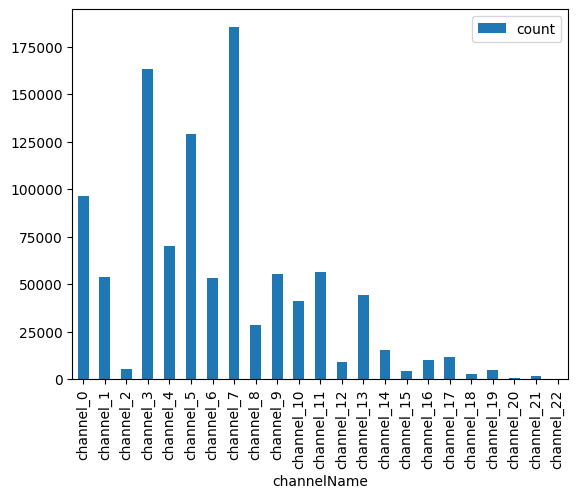

In [121]:
# Visualize how many calls that were solved by each channel
channel_grp_is_solved.loc[channel_grp_is_solved["is_solved"] == 1].plot(x="channelName", y="count", kind="bar")
plt.show()